In [1]:
#import the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #For plotting
from sklearn.cluster import KMeans #Do K-Means clustering
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator #Find the knee of the WCSS vs K plot
from yellowbrick.cluster import silhouette_visualizer #Plot Silhouette plot
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly
import plotly.express as px
import plotly.io as pio

In [2]:
#Importing the dataset
officeLat_data = pd.read_excel('RentalOfficeData_Location_JanNov2018.xlsx')
officeLat_data.head()

,Unnamed: 0,month,code,rentals,returns,location_map,latitude,logitude
0,0,201806,101.0,832,807,"(37.549561, 126.905754)",37.549561,126.905754
1,1,201806,102.0,2819,2568,"(37.5556488, 126.9106293)",37.555649,126.910629
2,2,201806,103.0,1977,1769,"(37.55495071, 126.9108353)",37.554951,126.910835
3,3,201806,104.0,1682,1610,"(37.55062866, 126.9149857)",37.550629,126.914986
4,4,201806,105.0,1105,925,"(37.55000687, 126.9148254)",37.550007,126.914825


In [3]:
officeLat_data.drop(columns= ['month','code', 'location_map', 'Unnamed: 0'],inplace=True) #these columns are not useful in our groupings 
officeLat_data.head()

,rentals,returns,latitude,logitude
0,832,807,37.549561,126.905754
1,2819,2568,37.555649,126.910629
2,1977,1769,37.554951,126.910835
3,1682,1610,37.550629,126.914986
4,1105,925,37.550007,126.914825


In [4]:
officeLat_data.describe()

,rentals,returns,latitude,logitude
count,15050.000000,15050.000000,14629.000000,14629.000000
mean,695.789369,693.912957,37.544458,126.983046
std,681.807015,717.951061,0.314601,1.053506
min,0.000000,0.000000,0.000000,0.000000
25%,243.000000,220.000000,37.505852,126.918953
50%,514.000000,496.000000,37.545952,127.002838
75%,937.000000,939.000000,37.577675,127.059151
max,12207.000000,12332.000000,37.689720,127.180267


In [10]:
#Removing all rows with empty values
nan_value = float("NaN")
#Convert NaN values to empty string

officeLat_data.replace("", nan_value, inplace=True)

#df.dropna(subset = ["column2"], inplace=True)
officeLat_data.dropna(subset = ["latitude"], inplace=True)

#officeLat_data['rentals'].isna().sum()

In [11]:
officeLat_data.describe()

,rentals,returns,latitude,logitude
count,14629.000000,14629.000000,14629.000000,14629.000000
mean,700.449313,697.584114,37.544458,126.983046
std,686.903551,721.834695,0.314601,1.053506
min,0.000000,0.000000,0.000000,0.000000
25%,245.000000,222.000000,37.505852,126.918953
50%,516.000000,498.000000,37.545952,127.002838
75%,943.000000,944.000000,37.577675,127.059151
max,12207.000000,12332.000000,37.689720,127.180267


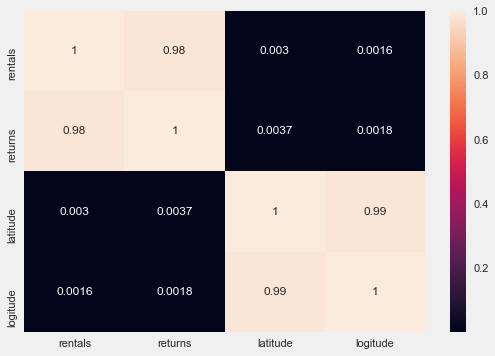

In [25]:
corrMatrix = officeLat_data.corr()
sns.heatmap(corrMatrix, annot=True, annot_kws={"size": 12})
plt.show()

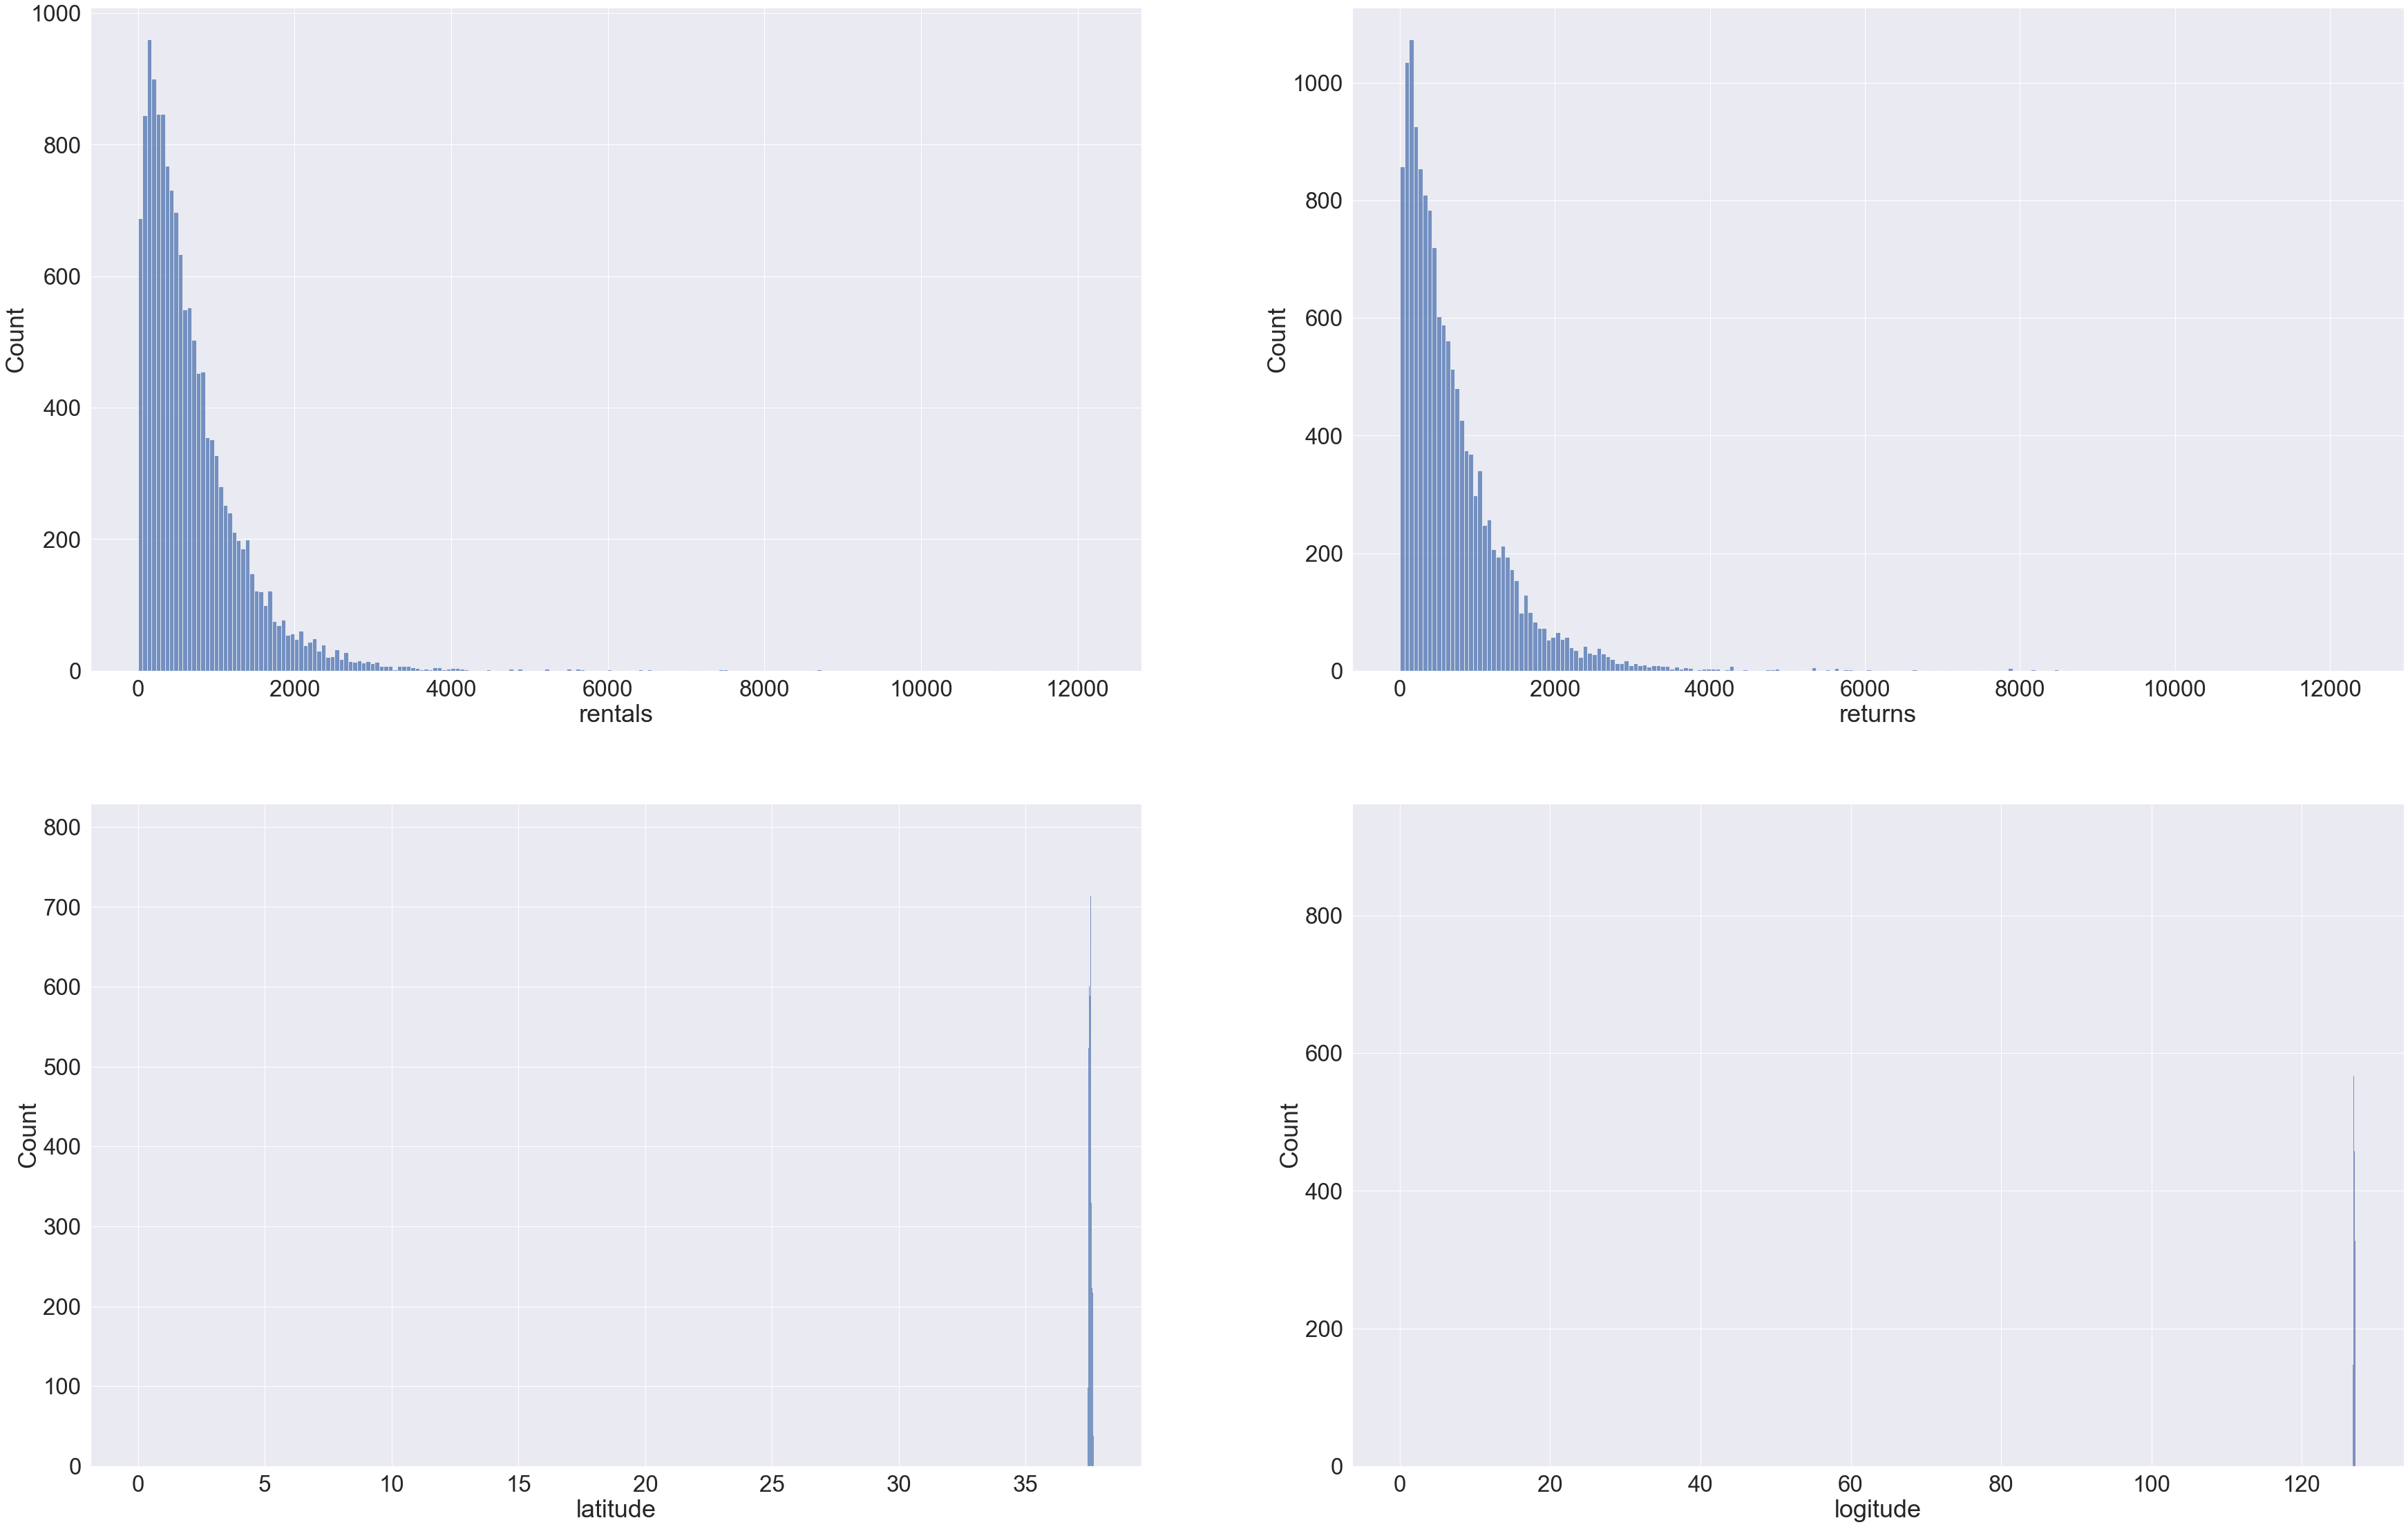

In [17]:
#Do a visual check to get a sense on how we can group some features
plt.figure(figsize=(60,60))
sns.set(font_scale = 3)
for i in range(len(officeLat_data.columns)):
    plt.subplot(3,2,i+1)
    freshplot = sns.histplot(officeLat_data.iloc[:,i])

In [18]:
#if the columns are too skewed, this is a method that scales each column of a dataframe, the output is a numpy array 
dataarray = officeLat_data.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) #Scaling inputs if required

### Elbow method with Total WCSS vs Number of Clusters

In [19]:
wcss = []
max_k = 14 # NOTE: Try 10 and 20
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    wcss.append(kmeans.inertia_)

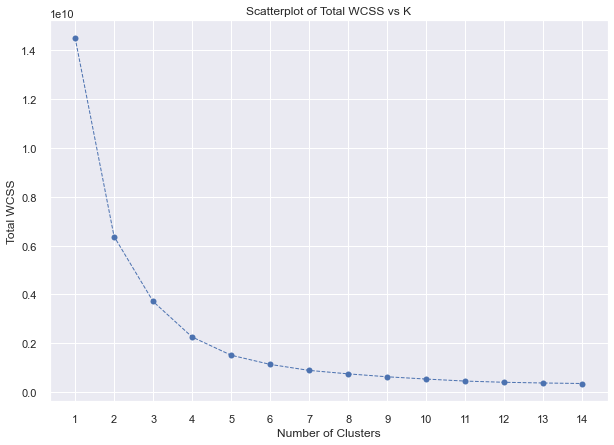

In [20]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [21]:
#To locate the elbow point of the curve using kneed package
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

4

### Silhouette width plot

In [22]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataarray)
    score = silhouette_score(dataarray, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

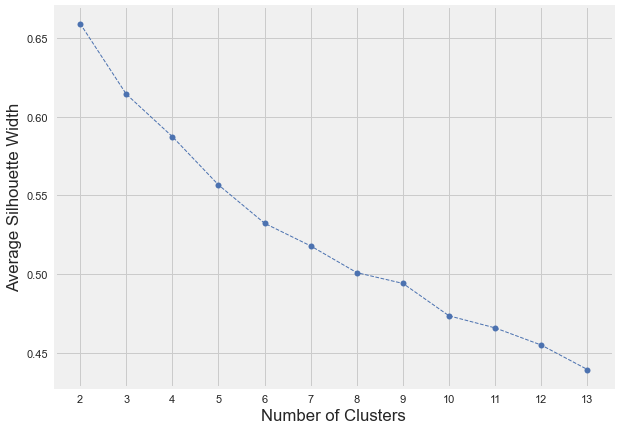

In [23]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### Running the K-means on scaled data

In [26]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

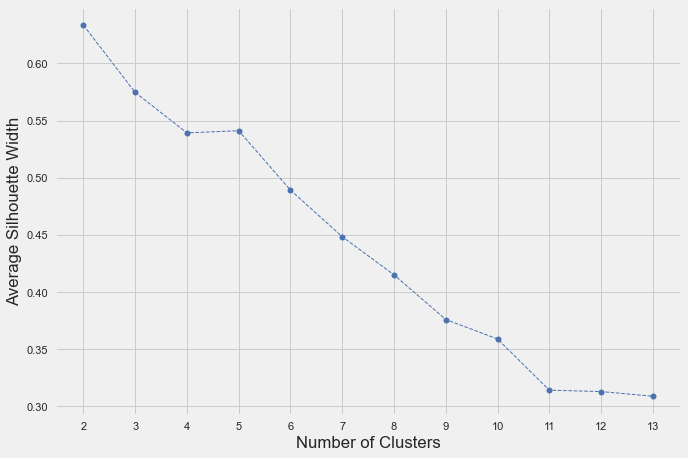

In [27]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### K-Means Clustering Algorithm Implementation

In [28]:
#silhouette dictionary to track the silhouette scores for different k 
silhouette_dict = {}

In [29]:
#Fit kmeans labels onto our dataframe
#Input: df and int, Output:df 
def kmeans_label(data, num_clusters): 
  kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
  kmeans_model.fit(data.to_numpy())
  data2 = data.copy()
  labels = kmeans_model.labels_
  data2['Clusters'] = pd.DataFrame(labels)
  return data2

In [30]:
#Plot boxplots of each feature after attaching cluster label in each row
#Input: df with labels, Output: plt graphs
def plot_boxplots(data_with_label):
  plt.figure(figsize=(30,30))
  sns.set(font_scale = 2)
  for i in range(len(data_with_label.columns)-1):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 


In [31]:
#Plot the silhouettes
#Input: df, Output: plt graphs
def plot_silhouettes(data,num_clusters):
  dataarray = data.to_numpy()
  model = KMeans(num_clusters,random_state=42)
  plt.figure(figsize=(10, 7)) 
  sns.set(font_scale = 1)
  silhouette_visualizer(model, dataarray, colors='yellowbrick')
  score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
  if num_clusters not in silhouette_dict.keys():
    silhouette_dict[num_clusters] = score
  print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))


### K-means with 4 clusters

In [32]:
kmeans4 = KMeans(init="random",n_clusters =4 , random_state = 42)
kmeans4.fit(dataarray)
clustergroups4 = kmeans4.labels_ #The cluster number for each row

In [33]:
Clustercenters4 = pd.DataFrame(kmeans4.cluster_centers_) #Dataframe of cluster centers
Clustercenters4.rename(columns={0: "Num_Rental", 1: "Num_Return", 2: "Latitute", 3: "logitude"},inplace=True)
Clustercenters4.index.name = "Clusters"

In [34]:
Clustercenters4

,Num_Rental,Num_Return,Latitute,logitude
Clusters,,,,
0,308.584837,289.653916,37.541920,126.976864
1,5234.238095,5591.750000,37.534183,126.984252
2,2086.934872,2149.281121,37.548571,126.987859
3,999.816135,1003.800612,37.548417,126.993586


In [35]:
from decimal import Decimal
print(kmeans4.inertia_)
print('%.1E' % Decimal(kmeans4.inertia_))

2256006757.4175005
2.3E+09


In [36]:
model4 = kmeans_label(officeLat_data, 4) #Attach kmeans_labels to our markets_data
model4.head() # which cluster each row belongs to

,rentals,returns,latitude,logitude,Clusters
0,832,807,37.549561,126.905754,3.0
1,2819,2568,37.555649,126.910629,2.0
2,1977,1769,37.554951,126.910835,2.0
3,1682,1610,37.550629,126.914986,2.0
4,1105,925,37.550007,126.914825,3.0


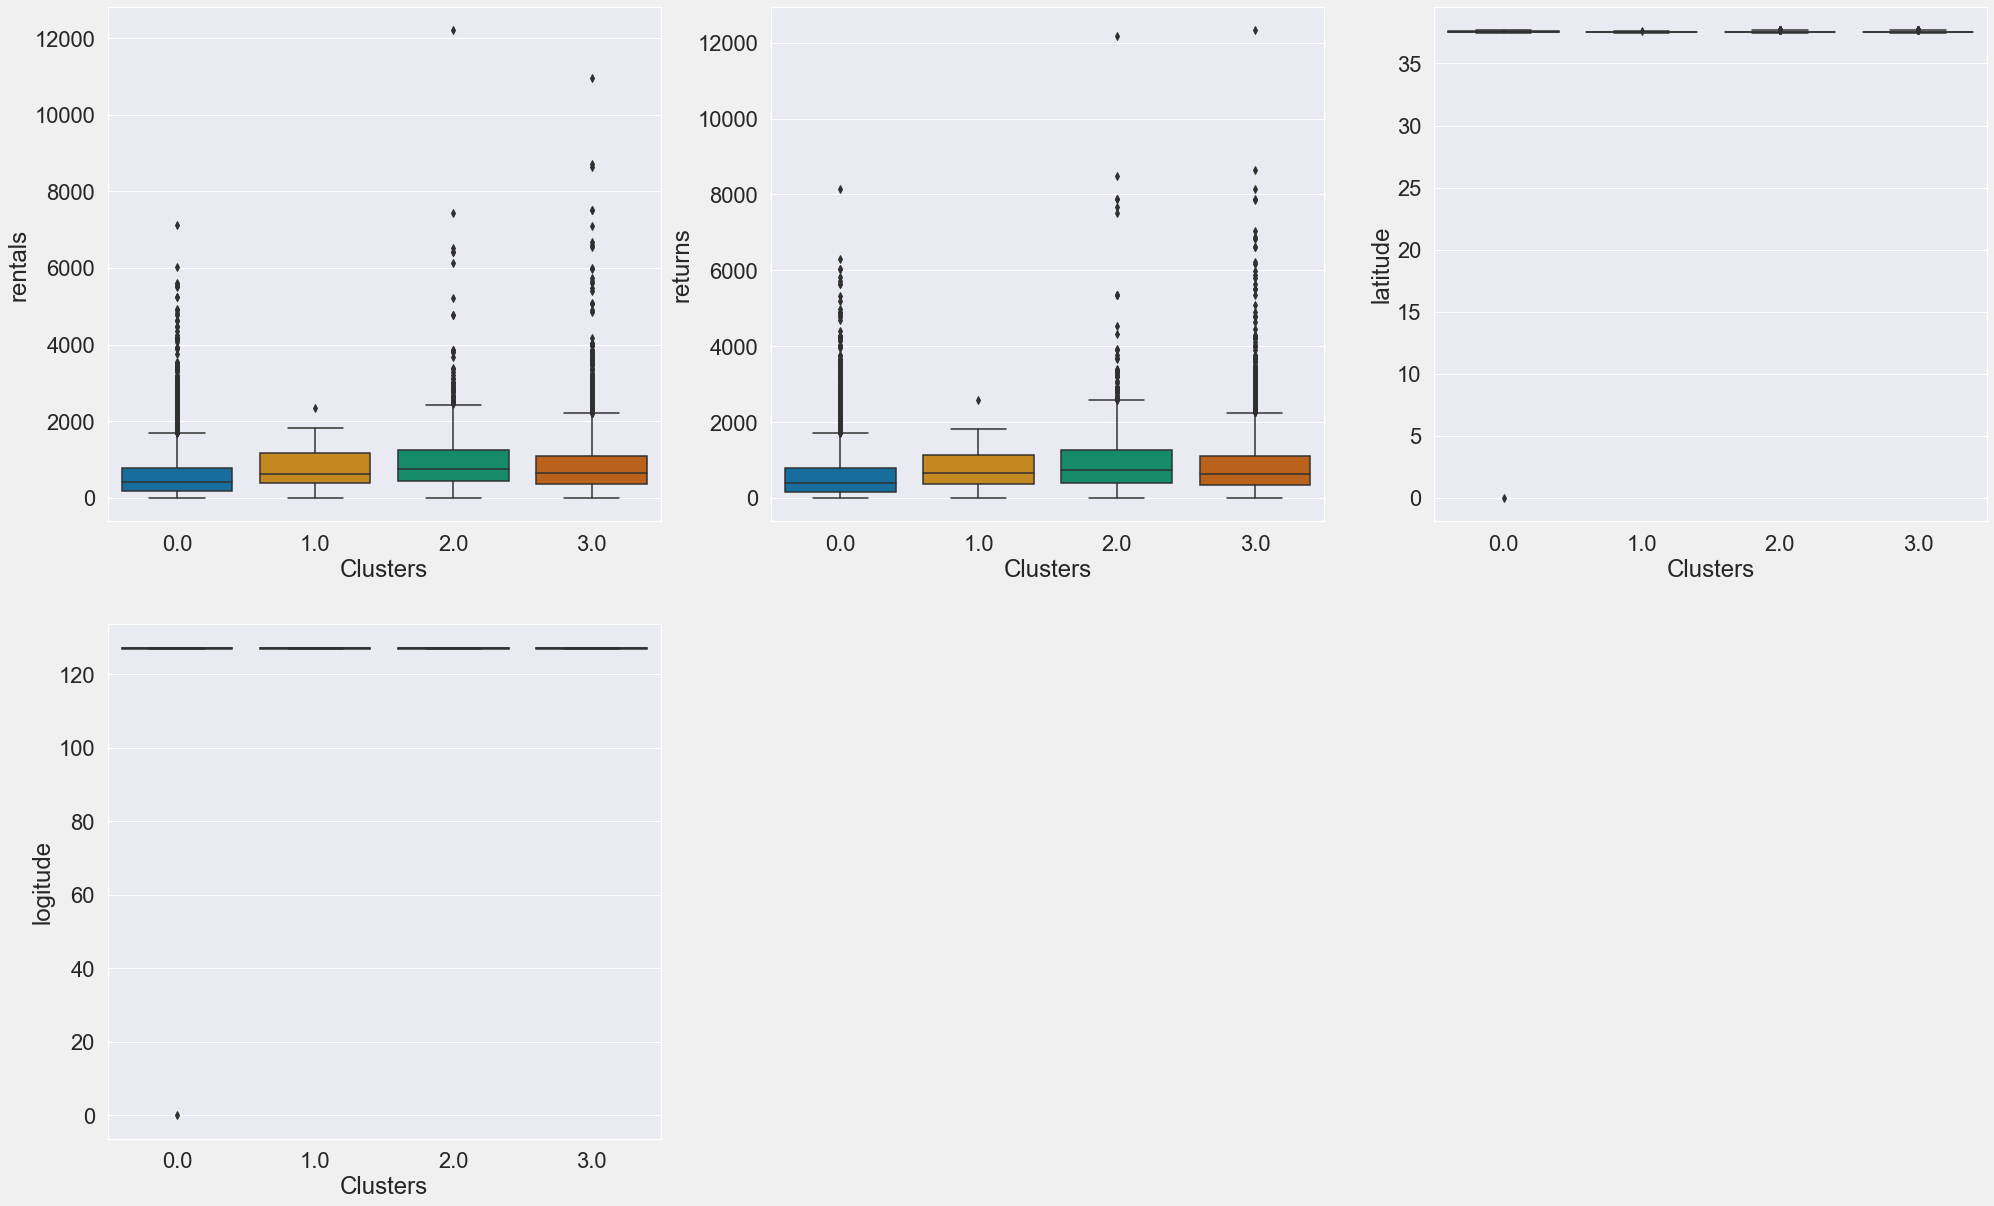

In [37]:
plot_boxplots(model4)

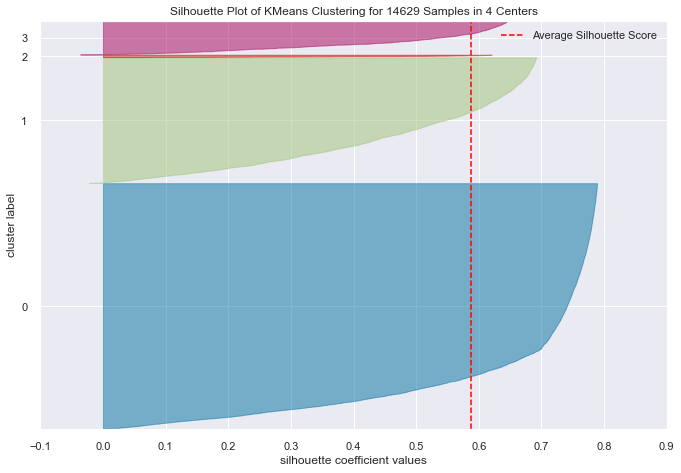

For n_clusters = 4 The average silhouette_score is: 0.587805933524844 


In [39]:
plot_silhouettes(officeLat_data,4)

In [40]:
model4.Clusters.value_counts(dropna = False)

0.0    8519
3.0    4442
2.0    1179
NaN     411
1.0      78
Name: Clusters, dtype: int64

In [45]:
officeLat_data['logitude'].isna().sum()

0

In [46]:
officeLat_data.head()

,rentals,returns,latitude,logitude
0,832,807,37.549561,126.905754
1,2819,2568,37.555649,126.910629
2,1977,1769,37.554951,126.910835
3,1682,1610,37.550629,126.914986
4,1105,925,37.550007,126.914825


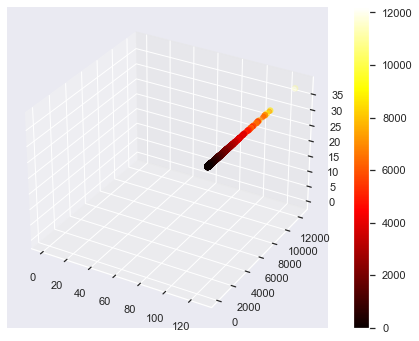

In [55]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = model4.rentals
y = model4.returns
z = model4.latitude
c = model4.logitude

img = ax.scatter(c, y, z, c=x, s = model4.Clusters*10, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [63]:
import pandas as pd
import plotly
import plotly.graph_objs as go


#Set marker properties
markersize = model4.Clusters.dropna()
markercolor = model4.rentals

#Make Plotly figure
fig1 = go.Scatter3d(x= model4.returns,
                    y= model4.latitude,
                    z= model4.logitude,
                    marker=dict(size=markersize,
                                color=markercolor,
                                opacity=0.9,
                                reversescale=True,
                                colorscale='Blues'),
                    line=dict (width=0.02),
                    mode='markers')

#Make Plot.ly Layout
mylayout = go.Layout(scene=dict(xaxis=dict( title="Returns"),
                                yaxis=dict( title="Latitude"),
                                zaxis=dict(title="Logitude")),)

#Plot and save html
plotly.offline.plot({"data": [fig1],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("5D Plot.html"))


'5D Plot.html'

In [56]:
model4.Clusters

0        3.0
1        2.0
2        2.0
3        2.0
4        3.0
        ... 
15045    NaN
15046    NaN
15047    NaN
15048    NaN
15049    NaN
Name: Clusters, Length: 14629, dtype: float64

In [67]:
fig = px.scatter(model4.dropna(), x='rentals', y='logitude',
                    color='Clusters')
fig.show()

In [69]:
model4.describe()

,rentals,returns,latitude,logitude,Clusters
count,14629.000000,14629.000000,14629.000000,14629.000000,14218.000000
mean,700.449313,697.584114,37.544458,126.983046,1.108595
std,686.903551,721.834695,0.314601,1.053506,1.385684
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,245.000000,222.000000,37.505852,126.918953,0.000000
50%,516.000000,498.000000,37.545952,127.002838,0.000000
75%,943.000000,944.000000,37.577675,127.059151,3.000000
max,12207.000000,12332.000000,37.689720,127.180267,3.000000
